# Comparing AirPublic sensor data with LAQN

Below one can explore the data from our first field trial. We placed our small AirPublic sensor next to the large London Air Quality Network container in Marylebone. The sensors seem to correlate quite well. 

You are welcome to play more with the data below.

In [1]:
import xarray as xr
import pandas as pd
import seaborn as sns


from matplotlib import pyplot as plt
%matplotlib inline

In [5]:
df_airpublic = pd.read_csv('airpublic_sensor.csv')

In [6]:
start = '2016-08-07 00:00:00'
end = '2016-09-22 00:00:00'

def filter_by_time(df):
    time = (df.datetime > start) & (df.datetime < end)
    return df[time]

In [7]:
def clean(df):
    df['datetime'] = pd.to_datetime(df.timestamp)
    df['timestamp'] = pd.to_datetime(df.timestamp)    
    
    df = df.sort_values(by='datetime')
    
    sane_gps = (df.latitude > 0) & (df.gps_fix == 1)
    # Marylebeone site has code MY1 and these GPS coords
    my1_site = (df.longitude > -0.155) & (df.longitude <  -0.154) & (df.latitude > 51.52) &  (df.latitude < 51.53 )
    cleaned_df = df[sane_gps & my1_site]
    count_clean = len(cleaned_df)
    count_all = len(df)
    print 'Removed %s rows' % (count_all - count_clean)
    print 'Remaining %s rows' % (count_clean)
    
    # Warning: the computer timezone must be gmt in order to match kings
    # assuming only one sensor
    cleaned_df = cleaned_df.set_index('datetime')  
    
    return cleaned_df


In [12]:
def prep_kings(df_kings):
    df_kings['datetime'] = pd.to_datetime(df_kings.date)    
    df_kings = filter_by_time(df_kings)    
    df_kings = df_kings.set_index('datetime')    
    ds_kings = xr.Dataset.from_dataframe(df_kings)
    return ds_kings
   

In [9]:
df_airpublic = clean(df_airpublic)
ds = xr.Dataset.from_dataframe(df_airpublic)
ds_mean = ds.resample(freq='1H', dim='datetime', how='mean', skipna=True)


Removed 4679 rows
Remaining 37247 rows


In [13]:
df_kings = pd.read_csv('kings_sensor.csv')
ds_kings = prep_kings(df_kings)

In [15]:
ds_merged = xr.merge([ds_kings[['pm10', 'pm10_raw']].rename({'pm10': 'kings_vol_pm10', 'pm10_raw': 'kings_vol_pm10_raw'}), ds_mean], join='inner')


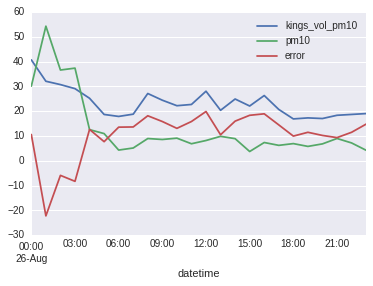

In [16]:
ds_merged_pm10 = ds_merged[['kings_vol_pm10','pm10']]
ds_merged_pm10['error'] = ds_merged['kings_vol_pm10'] - ds_merged['pm10']
ds_merged_pm10.sel(datetime='2016-08-26').to_dataframe().plot()

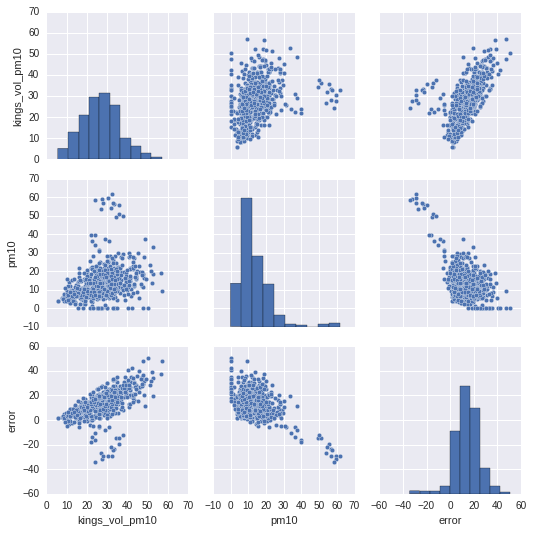

In [17]:
sns.pairplot(ds_merged_pm10.to_dataframe().dropna().reset_index(), vars=ds_merged_pm10.data_vars)

In [ ]:
h